In [1]:
# Bitcoin
# Ethereum
# Ripple
# Cardano
# Chainlink
# Polkadot


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
from binance import Client
from prophet import Prophet

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
API_KEY = 'Ymbp2TjX2YH1RktNKJJSYbOr5HMnLcmU9sQiLXvBlFa1L58U4b3qw39IBUSmGEWg'
API_SECRET = 'rxcCcIXHJNCpstXdZ2T8vr9tX9uXL2pWiLSkffr7UsDumU9pFPLHcRb9igB0Ktcn'
client = Client(API_KEY, API_SECRET)
client.get_all_tickers()

[{'symbol': 'ETHBTC', 'price': '0.05983400'},
 {'symbol': 'LTCBTC', 'price': '0.00352800'},
 {'symbol': 'BNBBTC', 'price': '0.00787800'},
 {'symbol': 'NEOBTC', 'price': '0.00092800'},
 {'symbol': 'QTUMETH', 'price': '0.00284800'},
 {'symbol': 'EOSETH', 'price': '0.00163000'},
 {'symbol': 'SNTETH', 'price': '0.00003584'},
 {'symbol': 'BNTETH', 'price': '0.00141800'},
 {'symbol': 'BCCBTC', 'price': '0.07908100'},
 {'symbol': 'GASBTC', 'price': '0.00020280'},
 {'symbol': 'BNBETH', 'price': '0.13172000'},
 {'symbol': 'BTCUSDT', 'price': '40226.98000000'},
 {'symbol': 'ETHUSDT', 'price': '2406.92000000'},
 {'symbol': 'HSRBTC', 'price': '0.00041400'},
 {'symbol': 'OAXETH', 'price': '0.00017780'},
 {'symbol': 'DNTETH', 'price': '0.00002801'},
 {'symbol': 'MCOETH', 'price': '0.00577200'},
 {'symbol': 'ICNETH', 'price': '0.00166300'},
 {'symbol': 'MCOBTC', 'price': '0.00021140'},
 {'symbol': 'WTCBTC', 'price': '0.00001402'},
 {'symbol': 'WTCETH', 'price': '0.00023700'},
 {'symbol': 'LRCBTC', 'p

In [4]:
plt.style.use('ggplot')

In [5]:
def crypto_DataFrame(crypto_Ticker):
# ----------------------------------------------------------------------------------------------------------------------
#   1.- JIC changing Ticker to all caps    
    crypto_Ticker = str(crypto_Ticker).upper()
# ----------------------------------------------------------------------------------------------------------------------
#   2.- Reading Bitcoin historical data
    df_1 = pd.read_csv(f'/Users/diegoperezo97/Documents/Ironhack – Data Analytics Bootcamp/Module 2/mini-project-4/{crypto_Ticker}.csv')
# ----------------------------------------------------------------------------------------------------------------------    
#   3.- Dropping 'Currency column'    
    df_1 = df_1.drop(columns=['Currency'])
# ----------------------------------------------------------------------------------------------------------------------
#   4.- Sorting DataFrame by date
    df_1 = df_1.sort_values(by='Date', ascending=True)
# ----------------------------------------------------------------------------------------------------------------------    
#   5.- Removing duplicates   
    df_1 = df_1[~df_1.index.duplicated(keep='first')]   
# ----------------------------------------------------------------------------------------------------------------------    
#   6.- Extracting data not available on the historical data from Binance API
    API_KEY = 'Ymbp2TjX2YH1RktNKJJSYbOr5HMnLcmU9sQiLXvBlFa1L58U4b3qw39IBUSmGEWg'
    API_SECRET = 'rxcCcIXHJNCpstXdZ2T8vr9tX9uXL2pWiLSkffr7UsDumU9pFPLHcRb9igB0Ktcn'
    client = Client(API_KEY, API_SECRET)
    last_date = df_1['Date'].tail(1).item()
    today = datetime.today().strftime('%Y-%m-%d')
    df_klines = client.get_historical_klines(f'{crypto_Ticker}TUSD', Client.KLINE_INTERVAL_1DAY, f'{last_date}', f'{today}')
# ----------------------------------------------------------------------------------------------------------------------        
#   7.- Converting extracted data into a Pandas Data Frame
    df_2 = pd.DataFrame(df_klines)   
# ----------------------------------------------------------------------------------------------------------------------            
#   8.- Converting extracted data into a Pandas Data Frame  
    df_2 = df_2[[1, 2, 3, 4]]
# ----------------------------------------------------------------------------------------------------------------------            
#   9.- Renaming columns
    df_2 = df_2.rename(columns={1: '24h Open (USD)', 2: '24h High (USD)', 3: '24h Low (USD)', 4: 'Closing Price (USD)'})
# ----------------------------------------------------------------------------------------------------------------------            
#   10.- Adding a new column with today's date
    df_2['Date'] = pd.date_range(start=f'{last_date}', end=f'{today}', periods=len(df_2))
# ----------------------------------------------------------------------------------------------------------------------            
#   11.- Creating a list with btc_1 Data Frame column names
    columns = df_1.columns
# ----------------------------------------------------------------------------------------------------------------------            
#   12.- Resorting btc_2 columns
    df_2 = df_2.reindex(columns=columns)
# ----------------------------------------------------------------------------------------------------------------------            
#   13.- Appending resulting btc_2 Data Frame to btc_1
    df_3 = df_1.append(df_2, ignore_index=True)
# ----------------------------------------------------------------------------------------------------------------------            
#   14.- Converting 'Date' column to datetime format
    df_3['Date'] = pd.to_datetime(df_3['Date'])
# ----------------------------------------------------------------------------------------------------------------------            
#   15.- Removing rows with the same date
    df_3 = df_3.drop_duplicates(subset=['Date'])
# ----------------------------------------------------------------------------------------------------------------------            
#   16.- Renaming 'Date' column as 'ds'
    df_3 = df_3.rename(columns={'Date': 'ds'})
# ----------------------------------------------------------------------------------------------------------------------            
#   17.- Setting 'ds' column as axis
    df_3 = df_3.set_index('ds')
# ----------------------------------------------------------------------------------------------------------------------            
#   18.- Changing columns to float
    df_3 = df_3.astype(float)
# ----------------------------------------------------------------------------------------------------------------------            
#   19.- Calculating row average and renaming '0' column as 'y'
    df_3 = pd.DataFrame(df_3.mean(axis=1)).rename(columns={0: 'y'}).loc['2021-01-01':]
# ----------------------------------------------------------------------------------------------------------------------            
#   20.- Slicing df_3 DataFrame to training and test sets  
    training = df_3[:'2021-05-31']
    test = df_3['2021-05-31':]
    
    return(training, test)

In [6]:
training, test = crypto_DataFrame('ETH')
training

,y
ds,
2021-01-01,734.431468
2021-01-02,750.485060
2021-01-03,875.990642
2021-01-04,1007.762078
2021-01-05,1067.951919
...,...
2021-05-27,2799.823333
2021-05-28,2553.336054
2021-05-29,2368.306115


In [7]:
# Naive 
dd = np.asarray(training['y'])
test['naive'] = dd[len(dd) - 1]

In [8]:
# Simple Average
test['s_avg'] = training['y'].mean()

In [9]:
# Moving Average
test['m_avg'] = training['y'].rolling(60).mean().iloc[-1]

In [10]:
# Weighted Moving Average
weights = np.arange(1, 71)
wma = (training['y']
    .rolling(70)
    .apply(lambda prices: np.dot(prices, weights)/weights.sum())
      ).dropna()[:61].to_list()
test['wm_avg'] = wma

In [11]:
x = test.apply(lambda x: x['naive'] - x['wm_avg'], axis=1)
test['wm_avg'] = [value + x[0] for value in wma]

In [12]:
# Exponential Moving Average
test['em_avg'] = training['y'][0:len(test)].ewm(span=len(training)).mean().to_list()
x = test.apply(lambda x: x['naive'] - x['em_avg'], axis=1)
test['em_avg'] = [value + x[0] for value in test['em_avg']]

In [13]:
# Simple Exponential Smoothing

fit2 = SimpleExpSmoothing(np.asarray(training['y'])).fit(smoothing_level=0.6,optimized=False)
test['ses'] = fit2.forecast(len(test))
test

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


,y,naive,s_avg,m_avg,wm_avg,em_avg,ses
ds,,,,,,,
2021-05-31,2498.351459,2498.351459,2005.926182,2723.583123,2498.351459,2498.351459,2456.267806
2021-06-01,2642.469200,2498.351459,2005.926182,2723.583123,2507.579379,2506.431413,2456.267806
2021-06-02,2668.194154,2498.351459,2005.926182,2723.583123,2517.675314,2551.515091,2456.267806
2021-06-03,2775.203761,2498.351459,2005.926182,2723.583123,2528.870144,2607.655176,2456.267806
2021-06-04,2750.777472,2498.351459,2005.926182,2723.583123,2537.601223,2653.694240,2456.267806
...,...,...,...,...,...,...,...
2021-07-26,2255.607958,2498.351459,2005.926182,2723.583123,3220.862629,3248.113612,2456.267806
2021-07-27,2250.132500,2498.351459,2005.926182,2723.583123,3260.255378,3247.941040,2456.267806
2021-07-28,2293.827500,2498.351459,2005.926182,2723.583123,3305.176927,3246.193558,2456.267806


In [14]:
# Holt's Linear Trend Method

fit1 = Holt(np.asarray(training['y'])).fit(smoothing_level=0.3,smoothing_slope =0.01)
test['holt_linear'] = fit1.forecast(len(test))

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-14-5b308183cf24>:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = Holt(np.asarray(training['y'])).fit(smoothing_level=0.3,smoothing_slope =0.01)


In [15]:
training

,y
ds,
2021-01-01,734.431468
2021-01-02,750.485060
2021-01-03,875.990642
2021-01-04,1007.762078
2021-01-05,1067.951919
...,...
2021-05-27,2799.823333
2021-05-28,2553.336054
2021-05-29,2368.306115


In [17]:
model = Prophet()
model.fit(training.reset_index())
today = datetime.today().strftime('%Y-%m-%d')
today = datetime.strptime(today, '%Y-%m-%d')
beginning_period = datetime.strptime('2021-05-31', '%Y-%m-%d')
timedelta = str(today - beginning_period)
tiemdelta = int(timedelta[0])
future = model.make_future_dataframe(60)[150:]
test['prophet'] = list(model.predict(future)['yhat'])
x = test.apply(lambda x: x['prophet'] - x['naive'], axis=1)
test['prophet'] = [value - x[0] for value in test['prophet']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


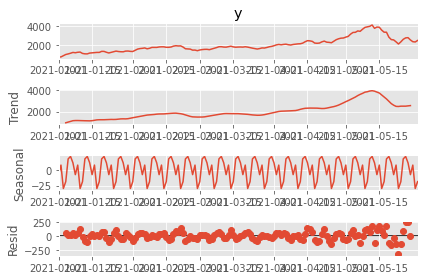

In [18]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(training['y']).plot()
result = sm.tsa.stattools.adfuller(training['y'])
plt.savefig('eth_decomposition.png')

In [ ]:
training['y'].plot(figsize=(15,8), c='red', label='Training Data')
test['y'].plot(figsize=(15,8), c='blue', label='Test Data')
test['naive'].plot(figsize=(15,8), c='green', label='Naive')
test['s_avg'].plot(figsize=(15,8), c='purple', label='Simple Average')
test['m_avg'].plot(figsize=(15,8), c='cyan', label='Moving Average')
test['wm_avg'].plot(figsize=(15,8), c='m', label='Weighted Moving Average')
test['em_avg'].plot(figsize=(15,8), c='y', label='Exponential Moving Average')
test['ses'].plot(figsize=(15,8), c='orange', label='Simple Exponential Smoothing')
test['holt_linear'].plot(figsize=(15,8), c='brown', label="Holt's Linear")
test['prophet'].plot(figsize=(15,8), c='k', label="Prophet")
plt.title('PolkaDot Market Capitalization', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Market Capitalization [$ USD]')
plt.legend(loc='best')
plt.savefig('dot.png')

In [ ]:
sme = pd.DataFrame(index=test.columns)

sme['sme'] = [sqrt(mean_squared_error(test['y'], test[col])) for col in test]
sme = sme.sort_values(by='sme', ascending=False).drop(index='y')
sme.to_csv(f'/Users/diegoperezo97/Documents/Ironhack – Data Analytics Bootcamp/Module 2/mini-project-4/dot_sme.csv')

In [ ]:
sme